<a href="https://colab.research.google.com/github/Kaan-wq/ml_tokamak/blob/main/NN_general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os
import glob
import numpy as np
from typing import Iterable
import pickle
import tensorflow as tf
from scipy.fft import fft, ifft
from statsmodels.tsa.stattools import acf, pacf
from sklearn.decomposition import PCA

import keras
import keras_tuner as kt
from kerastuner import RandomSearch
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers

#**I - Preprocessing of the data**

Below is the preprocessing pipeline of the data. \\
Essentially, we feature engineer a few columns, normalize the data and finally, we split it into a training and testing set.

In [74]:
# load dataset using pickle
import pickle
with open("../data/dataset_disruption_characterization.pickle", "rb") as f:
    dataset = pickle.load(f)

Here we load the data from the drive and put it into a more practical **data structure**. \\
We add a column <code>['IPE']</code> which represents the current difference between the reference and actual currents.

In [75]:
df_data = pd.DataFrame()

# Loop through each entry in the dataset
for i, entry in enumerate(dataset):
    # Extract data and label from the current entry
    d = entry['x']
    label = entry['y']
    metadata = entry['metadata']
    event = metadata['time_event']

    # Create a DataFrame for the current entry
    df = pd.DataFrame(d['data'], columns=d['columns'])

    # Add the IPE column
    df['IPE'] = np.abs(df['IPLA'] - df['IPref'])

    # Define columns to perform feeture engineering on
    column = ['IPLA', 'IPref', 'IPE', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG', 'Vloop']

    # Add the Fourier Transform columns
    for col in column:
      # Perform the Fourier Transform
      df[col + '_fft'] = np.fft.fft(df[col])

      # The result is complex numbers, you might want to take absolute value (magnitude) of the result
      df[col + '_fft_abs'] = np.abs(df[col + '_fft'])

      # Drop the column with complex numbers
      df = df.drop(columns=[col + '_fft'])


    # Add the first order derivative columns
    for col in column:
      # Perform the first order derivative
      df[col + '_der'] = np.gradient(df[col])

    # Add the second order derivative columns
    for col in column:
      # Perform the second order derivative
      df[col + '_der2'] = np.gradient(df[col + '_der'])

    # Add the autocorrelation columns
    for col in column:
      if df[col].isna().any() or np.isinf(df[col]).any() or df[col].nunique() <= 1:
        df[col + '_acf'] = 0

      else:
        df[col + '_acf'] = acf(df[col]).mean()
    
    # Add the partial autocorrelation columns
    for col in column:
      if df[col].isna().any() or np.isinf(df[col]).any() or df[col].nunique() <= 1:
        df[col + '_pacf'] = 0
      else:
        df[col + '_pacf'] = pacf(df[col]).mean()
    
    # Add the time column
    df['Time'] = d['time']

    # Add the Frame, Event, Label, Shot and Window columns
    df['Frame'] = range(0, 20)
    df['Event'] = event if event else 0

    if event:
      #Find closest points to time_event
      differences = np.abs(df['Time'] - event)
      closest_indices = np.argsort(differences)[:20]

      #Assign labels to closest points
      df['Label'] = 0
      df.loc[closest_indices, 'Label'] = label
    else:
      df['Label'] = label

    df['Shot'] = metadata['shot']
    df['Window'] = i  # Add the window number

    contains_nan = df.isna().any().any()

    if not contains_nan:
      # Append the current DataFrame to the main DataFrame
      df_data = pd.concat([df_data, df], ignore_index=True)


df_data = df_data.dropna()
display(df_data)
print("Labels count:")
print(f"{df_data['Label'].value_counts()}")

base_col = df_data.columns

In [66]:
shot = df_data[df_data['Label'] == 2]['Shot'].unique()[6]

# Filter the DataFrame to only include a specific shot
df_shot = df_data[df_data['Shot'] == shot]

# Filter the DataFrame to only include rows with labels clustered
df_label_2 = df_shot[df_shot['Label'] == 2]
df_label_1 = df_shot[df_shot['Label'] == 1]
df_label_0 = df_shot[df_shot['Label'] == 0]

# Select a specific window for each label
window_number_2 = df_label_2['Window'].unique()[0] 
df_window_2 = df_label_2[df_label_2['Window'] == window_number_2]

window_number_1 = df_label_1['Window'].unique()[0] 
df_window_1 = df_label_1[df_label_1['Window'] == window_number_1]

window_number_0 = df_label_0['Window'].unique()[0]
df_window_0 = df_label_0[df_label_0['Window'] == window_number_0]

# Plot each feature across time
features = df_data.columns.drop(['Label', 'Window', 'Shot', 'Frame', 'Time', 'Event'])  # Exclude non-feature columns

# Print the time of the event
print("Time of the event for each label is :")
print(f"Label 2: {df_window_2['Event'].unique()[0]}")
print(f"Label 1: {df_window_1['Event'].unique()[0]}")
print(f"Label 0: {df_window_0['Event'].unique()[0]}")

# Create a subplot for each feature
fig, axs = plt.subplots(len(features), 3, figsize=(20, 6*len(features)))

for i, feature in enumerate(features):
    axs[i, 0].plot(df_window_2['Time'], df_window_2[feature], label=f'Label 2')
    axs[i, 0].set_title(f'Feature: {feature} over Time for Window: {window_number_2}')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel(feature)
    axs[i, 0].legend()

    axs[i, 1].plot(df_window_1['Time'], df_window_1[feature], label=f'Label 1')
    axs[i, 1].set_title(f'Feature: {feature} over Time for Window: {window_number_1}')
    axs[i, 1].set_xlabel('Time')
    axs[i, 1].set_ylabel(feature)
    axs[i, 1].legend()

    axs[i, 2].plot(df_window_0['Time'], df_window_0[feature], label=f'Label 0')
    axs[i, 2].set_title(f'Feature: {feature} over Time for Window: {window_number_0}')
    axs[i, 2].set_xlabel('Time')
    axs[i, 2].set_ylabel(feature)
    axs[i, 2].legend()

plt.tight_layout()
plt.show()

# Save the plot in an image file
fig.savefig('../data/feature_time.png')

In [67]:
df_disr = df_data[df_data['Label'] != 0].drop(columns=['Window', 'Shot', 'Frame', 'Time', 'Event'])
df_disr.corr()['Label'].round(3).sort_values(ascending=False)

Label              1.000
Vloop_fft_abs      0.547
IPref_pacf         0.283
Vloop              0.192
IPLA_der2          0.186
LI                 0.185
IPLA_der           0.183
Vloop_der2         0.172
Vloop_der          0.169
LI_pacf            0.121
ZMAG_pacf          0.109
Q95_pacf           0.101
SSXcore_acf        0.093
ZMAG_acf           0.059
IPLA               0.058
IPLA_pacf          0.044
LI_acf             0.042
IPE_der2           0.034
IPref              0.033
SSXcore_der        0.031
IPE_der            0.026
IPLA_fft_abs       0.011
LI_der2            0.009
ZMAG_der           0.009
LI_der             0.007
IPref_der          0.006
LI_fft_abs         0.002
IPref_fft_abs      0.002
ZMAG_der2          0.002
IPE_fft_abs        0.000
IPref_der2        -0.003
Q95_fft_abs       -0.008
Q95_der2          -0.009
ZMAG_fft_abs      -0.012
ECEcore_fft_abs   -0.018
SSXcore_der2      -0.023
IPE_pacf          -0.024
Q95_der           -0.024
ECEcore_acf       -0.025
ZMAG              -0.029


In [18]:
df_data.columns

Index(['IPLA', 'IPref', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG', 'Vloop',
       'IPE', 'IPLA_fft_abs', 'IPref_fft_abs', 'IPE_fft_abs',
       'ECEcore_fft_abs', 'SSXcore_fft_abs', 'LI_fft_abs', 'Q95_fft_abs',
       'ZMAG_fft_abs', 'Vloop_fft_abs', 'IPLA_der', 'IPref_der', 'IPE_der',
       'ECEcore_der', 'SSXcore_der', 'LI_der', 'Q95_der', 'ZMAG_der',
       'Vloop_der', 'IPLA_der2', 'IPref_der2', 'IPE_der2', 'ECEcore_der2',
       'SSXcore_der2', 'LI_der2', 'Q95_der2', 'ZMAG_der2', 'Vloop_der2',
       'Time', 'Frame', 'Event', 'Label', 'Shot', 'Window'],
      dtype='object')

We **normalize and split** into training and test sets before feeding it into our **Neural Network**.

In [21]:
# Split 'Shot' values into training and test sets and create DataFrames
shot_train, shot_test = train_test_split(df_data['Shot'].unique(), test_size=0.2, random_state=42)
train_df = df_data[df_data['Shot'].isin(shot_train)]
test_df = df_data[df_data['Shot'].isin(shot_test)]

# Group by 'Window' and 'Shot', and reshape the data
train_df_grouped = train_df.sort_values(['Shot', 'Window', 'Time']).groupby(['Shot', 'Window'])
test_df_grouped = test_df.sort_values(['Shot', 'Window', 'Time']).groupby(['Shot', 'Window'])

# Prepare lists to hold sequences
X_train_grouped, y_train_grouped = [], []
X_test_grouped, y_test_grouped = [], []

# Generate sequences for training data
for _, group in train_df_grouped:
    X_train_grouped.append(group.drop(columns=['Frame', 'Event', 'Label', 'Shot', 'Window']).values)
    y_train_grouped.append(group['Label'].values[0])  # Assuming all labels in a group are the same

# Generate sequences for testing data
for _, group in test_df_grouped:
    X_test_grouped.append(group.drop(columns=['Frame', 'Event', 'Label', 'Shot', 'Window']).values)
    y_test_grouped.append(group['Label'].values[0])  # Assuming all labels in a group are the same

# Convert lists to numpy arrays
X_train_grouped = np.array(X_train_grouped)
y_train_grouped = np.array(y_train_grouped)
X_test_grouped = np.array(X_test_grouped)
y_test_grouped = np.array(y_test_grouped)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_grouped.reshape(-1, X_train_grouped.shape[-1])).reshape(X_train_grouped.shape)
X_test = scaler.transform(X_test_grouped.reshape(-1, X_test_grouped.shape[-1])).reshape(X_test_grouped.shape)

# Convert labels to categorical
y_train = to_categorical(y_train_grouped)
y_test = to_categorical(y_test_grouped)

In [22]:
X_train.shape

(737, 20, 37)

#**II - Model tuning**

Here we use the hyperparamter tuner from keras to find the best model architecture.

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

# Function for creating a residual block
def residual_block(x, filters, kernel_size):
    # Save the input value. Apply a 1x1 convolution to match the number of channels.
    residual = Conv1D(filters, 1, padding='same')(x)

    # Convolution, batch normalization, and ReLU activation (repeated three times)
    for _ in range(3):
        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Add the residual (input) to the output
    x = Add()([x, residual])

    return x

# Input shape: (timesteps, features)
input_shape = (20, 37)

# Input layer
input_layer = Input(shape=input_shape)

# Create three residual blocks with varying kernel sizes
x = residual_block(input_layer, 64, 8)
x = residual_block(x, 64, 5)
x = residual_block(x, 64, 3)

# Global Average Pooling layer
x = GlobalAveragePooling1D()(x)

# Final softmax classifier
output_layer = Dense(3, activation='softmax')(x)

# Create the model and compile it
model = Model(inputs=input_layer, outputs=output_layer)

# Create the optimizer
optimizer = Adam(learning_rate=1e-7)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(num_classes=3, average=None)])

# Print the model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20, 37)]             0         []                            
                                                                                                  
 conv1d_25 (Conv1D)          (None, 20, 64)               19008     ['input_3[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 20, 64)               256       ['conv1d_25[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 20, 64)               0         ['batch_normalization_18

Epoch 1/10000
24/24 [==============================] - 5s 33ms/step - loss: 0.9118 - accuracy: 0.6187 - f1_score: 0.3743 - val_loss: 0.9313 - val_accuracy: 0.6605 - val_f1_score: 0.3756
Epoch 2/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.9097 - accuracy: 0.6255 - f1_score: 0.3915 - val_loss: 0.9388 - val_accuracy: 0.6667 - val_f1_score: 0.3791
Epoch 3/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.9213 - accuracy: 0.6174 - f1_score: 0.3831 - val_loss: 0.9298 - val_accuracy: 0.6667 - val_f1_score: 0.3498
Epoch 4/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.9183 - accuracy: 0.6309 - f1_score: 0.4097 - val_loss: 0.9200 - val_accuracy: 0.7037 - val_f1_score: 0.3848
Epoch 5/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.8961 - accuracy: 0.6445 - f1_score: 0.3889 - val_loss: 0.9147 - val_accuracy: 0.7284 - val_f1_score: 0.3979
Epoch 6/10000
24/24 [==============================] - 0s 16ms/step - 

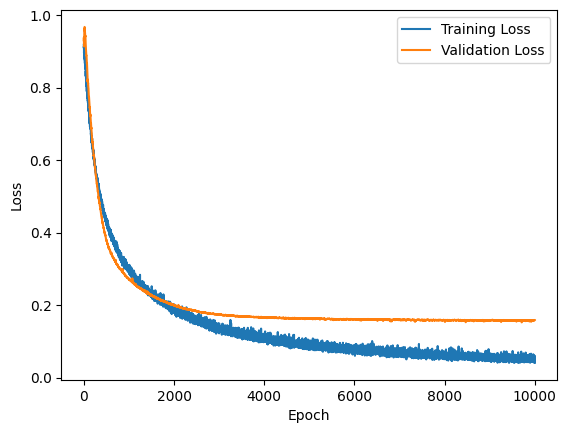

6/6 [==============================] - 0s 4ms/step - loss: 0.1590 - accuracy: 0.9568 - f1_score: 0.8984
F1-score on validation set: [0.9808429  0.85714287 0.85714287]


In [26]:
# Train the model
history = model.fit(X_train, y_train, epochs=10000, validation_data=(X_test, y_test))

# Plot the losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print the F1-score on the validation set
_, _, f1_score = model.evaluate(X_test, y_test)
print('F1-score on validation set:', f1_score)

#**III - Hyper-parameter tuning**

We use keras tuner to find the best hyper-parameters for our Residual Network.


In [31]:
import keras_tuner as kt

# Define the function to build the model with hyperparameters
def build_model(hp):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(3):
        # Define hyperparameters for the number of filters and kernel size
        filters = hp.Int('filters_' + str(i), min_value=32, max_value=128, step=32)
        kernel_size = hp.Choice('kernel_size_' + str(i), values=[3, 5, 8, 13, 21])

        x = residual_block(x, filters, kernel_size)

    x = GlobalAveragePooling1D()(x)
    # Final softmax classifier
    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Define hyperparameters for the learning rate
    learning_rate = 1e-4

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', tfa.metrics.F1Score(num_classes=3, average=None)]
    )

    return model

# Create the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train for each trial
    directory='my_dir',  # Directory where the hyperparameters will be saved
    project_name='resnet_hyperparam_tuning'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps.values)

Trial 10 Complete [00h 00m 39s]
val_loss: 0.1676895171403885

Best val_loss So Far: 0.11806707084178925
Total elapsed time: 00h 12m 46s
Best Hyperparameters:
{'filters_0': 64, 'kernel_size_0': 5, 'filters_1': 32, 'kernel_size_1': 13, 'filters_2': 32, 'kernel_size_2': 21}


In [51]:
# Input shape: (timesteps, features)
input_shape = (20, 37)

# Input layer
input_layer = Input(shape=input_shape)

# Create three residual blocks with varying kernel sizes
x = residual_block(input_layer, 128, 3)
x = residual_block(x, 96, 8)
x = residual_block(x, 32, 21)

# Global Average Pooling layer
x = GlobalAveragePooling1D()(x)

# Final softmax classifier
output_layer = Dense(3, activation='softmax')(x)

# Create the model and compile it
model_best = Model(inputs=input_layer, outputs=output_layer)

# Create the optimizer
optimizer = Adam(learning_rate=1e-6)

# Compile the model
model_best.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(num_classes=3, average=None)])

# Print the model summary
model_best.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 20, 37)]             0         []                            
                                                                                                  
 conv1d_109 (Conv1D)         (None, 20, 128)              14336     ['input_10[0][0]']            
                                                                                                  
 batch_normalization_81 (Ba  (None, 20, 128)              512       ['conv1d_109[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_81 (Activation)  (None, 20, 128)              0         ['batch_normalization_81

In [52]:
# Train the model
history_best = model_best.fit(X_train, y_train, epochs=10000, validation_data=(X_test, y_test))

# Plot the losses
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print the F1-score on the validation set
_, _, f1_score_best = model_best.evaluate(X_test, y_test)
print('F1-score on validation set:', f1_score_best)

Epoch 1/10000
24/24 [==============================] - 5s 48ms/step - loss: 2.3650 - accuracy: 0.2198 - f1_score: 0.1711 - val_loss: 1.5612 - val_accuracy: 0.1296 - val_f1_score: 0.1336
Epoch 2/10000
24/24 [==============================] - 1s 33ms/step - loss: 2.2986 - accuracy: 0.2157 - f1_score: 0.1623 - val_loss: 1.6050 - val_accuracy: 0.1296 - val_f1_score: 0.1319
Epoch 3/10000
24/24 [==============================] - 1s 32ms/step - loss: 2.2580 - accuracy: 0.2171 - f1_score: 0.1629 - val_loss: 1.6654 - val_accuracy: 0.1296 - val_f1_score: 0.1295
Epoch 4/10000
24/24 [==============================] - 1s 31ms/step - loss: 2.1959 - accuracy: 0.2293 - f1_score: 0.1780 - val_loss: 1.7241 - val_accuracy: 0.1111 - val_f1_score: 0.1026
Epoch 5/10000
24/24 [==============================] - 1s 32ms/step - loss: 2.1068 - accuracy: 0.2307 - f1_score: 0.1746 - val_loss: 1.7730 - val_accuracy: 0.1111 - val_f1_score: 0.1000
Epoch 6/10000
24/24 [==============================] - 1s 31ms/step - 

KeyboardInterrupt: 